## เราจะทำการทดสอบว่า โมเดลที่ถูกบันทึกไว้พร้อมไปใช้งานหรือไม่ และตรวจสอบฟังก์ชั่นในการทำนายผลลัพธ์

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot
%matplotlib inline

import ta
import catboost as ctb
import DeeperTradeLibrary as dpt
from sklearn.metrics import accuracy_score 
import datetime
import pickle

In [2]:
#สร้างฟังก์ชั่นในการ สร้าง Feature
def feature_generator(df_process):
    #ทำการคัดลอก df_process โดยใช้คำสั่ง copy เพื่อป้องกันไม่ให้ DataFrame ที่ส่งมาถูกแก้ไข
    df = df_process.copy()
    #เพิ่ม RSI 14 โดยใช้ ta
    df['rsi14'] = ta.momentum.rsi(df.close, n=14)
    #สร้าง Feature เพิ่มโดยนำ rsi จากแท่งก่อนหน้ามาประมวลผลร่วมด้วย
    df['rsi14-t1'] = df['rsi14'].shift(1)
    
    #สร้าง feature อื่นๆ ตามต้องการ
    df['open-close'] = df.open - df.close
    df['open-close-t1'] = df['open-close'].shift(1)
    df['high-low'] = df.high - df.low
    df['high-low-t1'] = df['high-low'].shift(1)
    
    #ทดลองสร้าง sma ในหลายๆ Period โดย loop
    for period in range(3,10):
        column_name = 'sma%d' % period
        df[column_name] = df.close.rolling(period).mean().diff()
    #สร้าง label ไว้สำหรับให้ ML ทำการเรียนรู้ โดยตัวอย่างคือการทำ Trend Follow โดยค่าผลต่างของเส้น MA ของวันก่อนหน้า
    #หากเป็นบวก แสดงว่าแท่งในวันรุ่งขึ้นจะมีแนวโน้มขึ้น
    df['label'] = (df.close.rolling(9, center=True).mean().diff() >= 0).astype(int)
    #Drop แถวที่มี na ทิ้งทั้งหมด
    df.dropna(inplace=True)
    #ส่งค่า DataFrame กลับไปที่เดิม
    return df

In [3]:
#นำเข้าข้อมูล
df_master = pd.read_csv('GOLD_H4.csv')
#เปลี่ยนช่อง time ให้อยู่ในรูปแบบ datetime
df_master['time'] = pd.to_datetime(df_master['time'])
#Drop ช่อง Volume ทิ้ง เพราะตัวอย่างนี้ไม่ได้ใช้ในการทำ Feature
df_master.drop('volume', axis=1, inplace=True)

In [4]:
df = feature_generator(df_master)

In [5]:
loded_model_file = pickle.load(open('model.pitsanu', "rb"))
model = loded_model_file['model']

In [6]:
pred = model.predict(df)

In [7]:
df['signal'] = pred

In [8]:
df

,time,open,high,low,close,rsi14,rsi14-t1,open-close,open-close-t1,high-low,high-low-t1,sma3,sma4,sma5,sma6,sma7,sma8,sma9,label,signal
9,2006-03-21 08:00:00,553.450,554.250,550.650,552.350,34.914319,42.818410,1.100,0.350,3.600,0.500,-0.666667,-0.41250,-0.4200,-0.233333,-0.542857,-0.425000,-0.188889,0,0.0
10,2006-03-21 12:00:00,552.350,553.450,547.050,549.850,24.048863,34.914319,2.500,1.100,6.400,3.600,-1.150000,-1.12500,-0.8300,-0.766667,-0.557143,-0.787500,-0.655556,0,0.0
11,2006-03-21 16:00:00,550.050,555.150,549.500,552.400,43.397981,24.048863,-2.350,2.500,5.650,6.400,-0.350000,-0.22500,-0.3900,-0.266667,-0.292857,-0.168750,-0.416667,0,0.0
12,2006-03-21 20:00:00,552.400,552.600,551.300,552.500,44.000479,43.397981,-0.100,-2.350,1.300,5.650,0.050000,-0.23750,-0.1600,-0.308333,-0.214286,-0.243750,-0.138889,0,0.0
13,2006-03-22 00:00:00,552.600,553.550,552.200,552.950,46.747494,44.000479,-0.350,-0.100,1.350,1.300,1.033333,0.15000,-0.1000,-0.058333,-0.200000,-0.131250,-0.166667,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22781,2020-01-31 04:00:00,1572.295,1576.761,1571.692,1576.476,52.633031,47.566437,-4.181,2.903,5.069,4.584,-1.146000,-1.81900,-0.7352,-0.863333,-0.537000,-0.084000,-0.030889,1,0.0
22782,2020-01-31 08:00:00,1576.526,1582.131,1576.203,1580.662,57.063031,52.633031,-4.136,-4.181,5.928,5.069,1.821000,0.18700,-0.6180,0.085000,-0.142000,0.053375,0.390444,0,0.0
22783,2020-01-31 12:00:00,1580.703,1589.127,1578.401,1588.277,63.711900,57.063031,-7.574,-4.136,10.726,5.928,5.341000,3.26950,1.6726,0.754167,1.160714,0.827625,0.893556,0,1.0
22784,2020-01-31 16:00:00,1588.221,1588.705,1581.024,1586.896,61.841624,63.711900,1.325,-7.574,7.681,10.726,3.473333,3.66050,2.3394,1.163667,0.449143,0.843000,0.582222,0,1.0


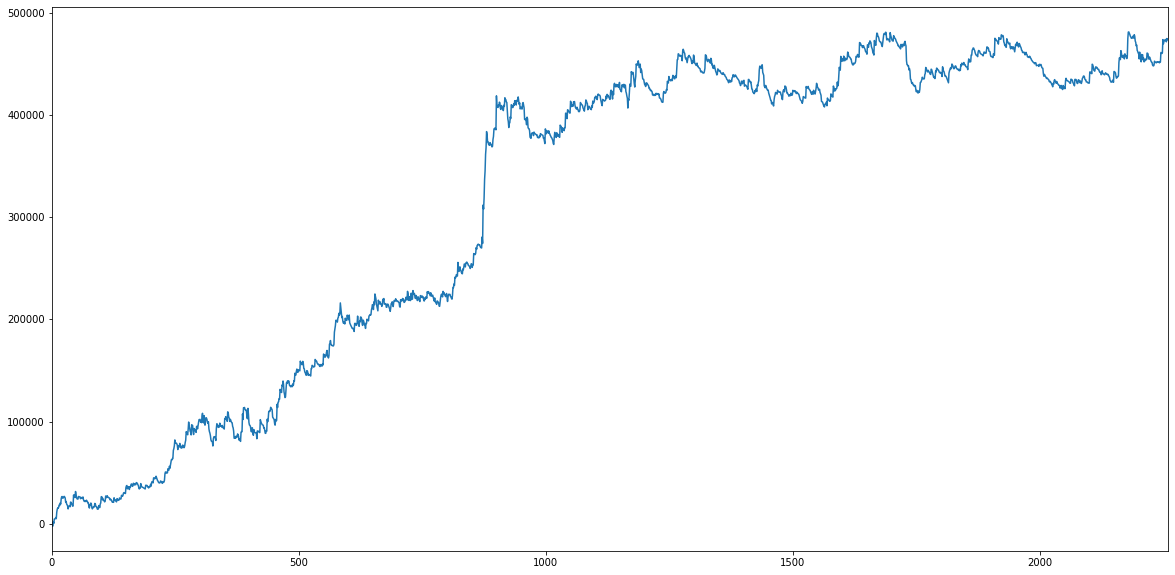

In [9]:
dpt.Backtest.trade_simulation(df.copy(), digit=1, pip_profit=30, commission=70).equity.plot(figsize=(20,10))

## ทดลองสร้างเงื่อนไขเพื่อเตรียมพร้อมไปใช้งานการเทรด

In [10]:
last_signal = model.predict(df)[-1]

In [11]:
if last_signal == 1:
    print('Long')
elif last_signal == 0:
    print('No position.')
elif last_signal == -1:
    print('Short')

Long
